## Model Metrics Analysis for LLaMa-2 benchmarking
---------
*This notebook works best with the conda_python3 kernel on a ml.t3.medium machine*.

### This part of our solution design includes the chunk of taking the metrics generated and creating visualizations from it for further analysis to make decisions more quicker, efficient, and cost optimal.

- In this file, we will go over and create side by side visualizations of different models deployed, how their inference latency is impacted based on the concurrency level, instance size and different model configurations. Using these visualizations and charts, making executive decisions, saving on time and cost becomes critical. 


- In this notebook, we will also record the error rates for each of the deployed model endpoints based on how it ran against different metrics as specified above. These visualizations will be applicable and work for any and every jumpstart and non jumpstart model if deployed correctly using the prior steps.

#### Import all of the necessary libraries below to run this notebook

In [2]:
import glob
import time
import json
import copy
import asyncio
import logging
import itertools
import sagemaker
import numpy as np
import pandas as pd

## Import seaborn and other related libraries for visualizations and plotting charts
import seaborn as sns
from globals import *
from datetime import datetime
from typing import Dict, List
from transformers import AutoTokenizer
from sagemaker.predictor import Predictor
from utils import load_config, count_tokens
from sagemaker.serializers import JSONSerializer

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
# Importing the necessary libraries for data visualization
import seaborn as sns # enhanced visualization capabilities

## for plotting
import matplotlib.pyplot as plt
# rcParams for configuring Matplotlib settings
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 10, 6

#### Pygmentize globals.py to view and use any of the globally initialized variables 

In [4]:
# global constants
!pygmentize globals.py

import os
import yaml
from enum import Enum
from pathlib import Path

CONFIG_FILE: str = "config.yml"
with open(CONFIG_FILE, 'r') as file:
    config = yaml.safe_load(file)

DATA_DIR: str = "data"
PROMPTS_DIR = os.path.join(DATA_DIR, "prompts")
METRICS_DIR = os.path.join(DATA_DIR, "metrics", config['general']['name'])
METRICS_PER_INFERENCE_DIR  = os.path.join(METRICS_DIR, "per_inference")
METRICS_PER_CHUNK_DIR  = os.path.join(METRICS_DIR, "per_chunk")
MODELS_DIR = os.path.join(DATA_DIR, "models", config['general']['name'])
DATASET_DIR = os.path.join(DATA_DIR, "dataset")
SCRIPTS_DIR: str = "scripts"
DIR_LIST = [DATA_DIR, PROMPTS_DIR, METRICS_DIR, MODELS_DIR, DATASET_DIR, METRICS_PER_INFERENCE_DIR, METRICS_PER_CHUNK_DIR]
TOKENIZER_DIR = 'llama2_tokenizer'

_ = list(map(lambda x: os.makedirs(x, exist_ok=True), DIR_LIST))

ENDPOINT_LIST_FPATH:str = os.path.join(MODELS_DIR, "endpoints.json")
REQUEST_PAYLOAD_FPATH:str = os.path.join(PROMPTS_DIR, "payload.jsonl")
RESULTS_FPATH:str = os.path.j

In [5]:
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

Load the Config.yml file contains information that is used across this benchmarking environment, such as information about the aws account, prompts, payloads to be used for invocations

In [6]:
config = load_config(CONFIG_FILE)
logger.info(json.dumps(config, indent=2))

[2024-01-19 01:00:14,930] p1570 {635462509.py:2} INFO - {
  "general": {
    "name": "llama2-13b-inf2-g5-p4d-v1"
  },
  "aws": {
    "region": "us-east-1",
    "sagemaker_execution_role": "arn:aws:iam::015469603702:role/SageMakerRepoRole"
  },
  "prompt": {
    "template_file": "prompt_template.txt",
    "all_prompts_file": "all_prompts.csv"
  },
  "datasets": [
    {
      "language": "en",
      "min_length_in_tokens": 1,
      "max_length_in_tokens": 500,
      "payload_file": "payload_{lang}_{min}-{max}.jsonl"
    },
    {
      "language": "en",
      "min_length_in_tokens": 500,
      "max_length_in_tokens": 1000,
      "payload_file": "payload_{lang}_{min}-{max}.jsonl"
    },
    {
      "language": "en",
      "min_length_in_tokens": 1000,
      "max_length_in_tokens": 2000,
      "payload_file": "payload_{lang}_{min}-{max}.jsonl"
    },
    {
      "language": "en",
      "min_length_in_tokens": 2000,
      "max_length_in_tokens": 3000,
      "payload_file": "payload_{lang}_{m

In [7]:
## Read the file path for the per inference request file that was generated after running all of the inferences
fpath: str = os.path.join(METRICS_DIR, config["results"]["per_inference_request_file"])
df_per_inference = pd.read_csv(fpath)
    
logger.info(f"{fpath} read into dataframe of shape {df_per_inference.shape}")
df_per_inference.head()



[2024-01-19 01:00:15,613] p1570 {1880090687.py:5} INFO - data/metrics/llama2-13b-inf2-g5-p4d-v1/per_inference_request_results.csv read into dataframe of shape (3995, 26)


,endpoint_name,prompt,do_sample,temperature,top_p,top_k,max_new_tokens,truncate,completion,prompt_tokens,...,ModelName,Image,S3Uri,OPTION_DTYPE,OPTION_MAX_ROLLING_BATCH_SIZE,OPTION_NEURON_OPTIMIZE_LEVEL,OPTION_N_POSITIONS,OPTION_ROLLING_BATCH,OPTION_TENSOR_PARALLEL_DEGREE,SAGEMAKER_MODEL_SERVER_WORKERS
0,llama-2-13b-inf2-48xlarge-1705617197,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.7,0.92,120,100,2637,Based on the information provided in Passage 4...,2637,...,meta-textgenerationneuron-llama-2-13b-f-2024-0...,763104351884.dkr.ecr.us-east-1.amazonaws.com/d...,s3://jumpstart-private-cache-prod-us-east-1/me...,fp16,4.0,2.0,4096.0,auto,24.0,1.0
1,llama-2-13b-g5-24xlarge-1705592062,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.7,0.92,120,100,2770,\nCaves\n```\n\nQuestion:\nWhich of these is t...,2770,...,meta-textgeneration-llama-2-13b-2024-01-18-22-...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,s3://jumpstart-private-cache-prod-us-east-1/me...,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,llama-2-13b-g5-24xlarge-1705592062,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.7,0.92,120,100,3891,Blow In The Wind\n\nQuestion: Which album has...,3891,...,meta-textgeneration-llama-2-13b-2024-01-18-22-...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,s3://jumpstart-private-cache-prod-us-east-1/me...,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,llama-2-13b-inf2-24xlarge-1705617198,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.7,0.92,120,100,2440,The Siege Perilous was a vacant seat at King A...,2440,...,meta-textgenerationneuron-llama-2-13b-f-2024-0...,763104351884.dkr.ecr.us-east-1.amazonaws.com/d...,s3://jumpstart-private-cache-prod-us-east-1/me...,fp16,4.0,2.0,4096.0,auto,12.0,1.0
4,llama-2-13b-g5-24xlarge-1705617197,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.7,0.92,120,100,3436,Patnam Vachina Pativrathalu\n```\n\n```\nPass...,3436,...,meta-textgeneration-llama-2-13b-2024-01-18-22-...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,s3://jumpstart-private-cache-prod-us-east-1/me...,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### Relationship between prompt token length and inference latency for different instances and concurrency levels

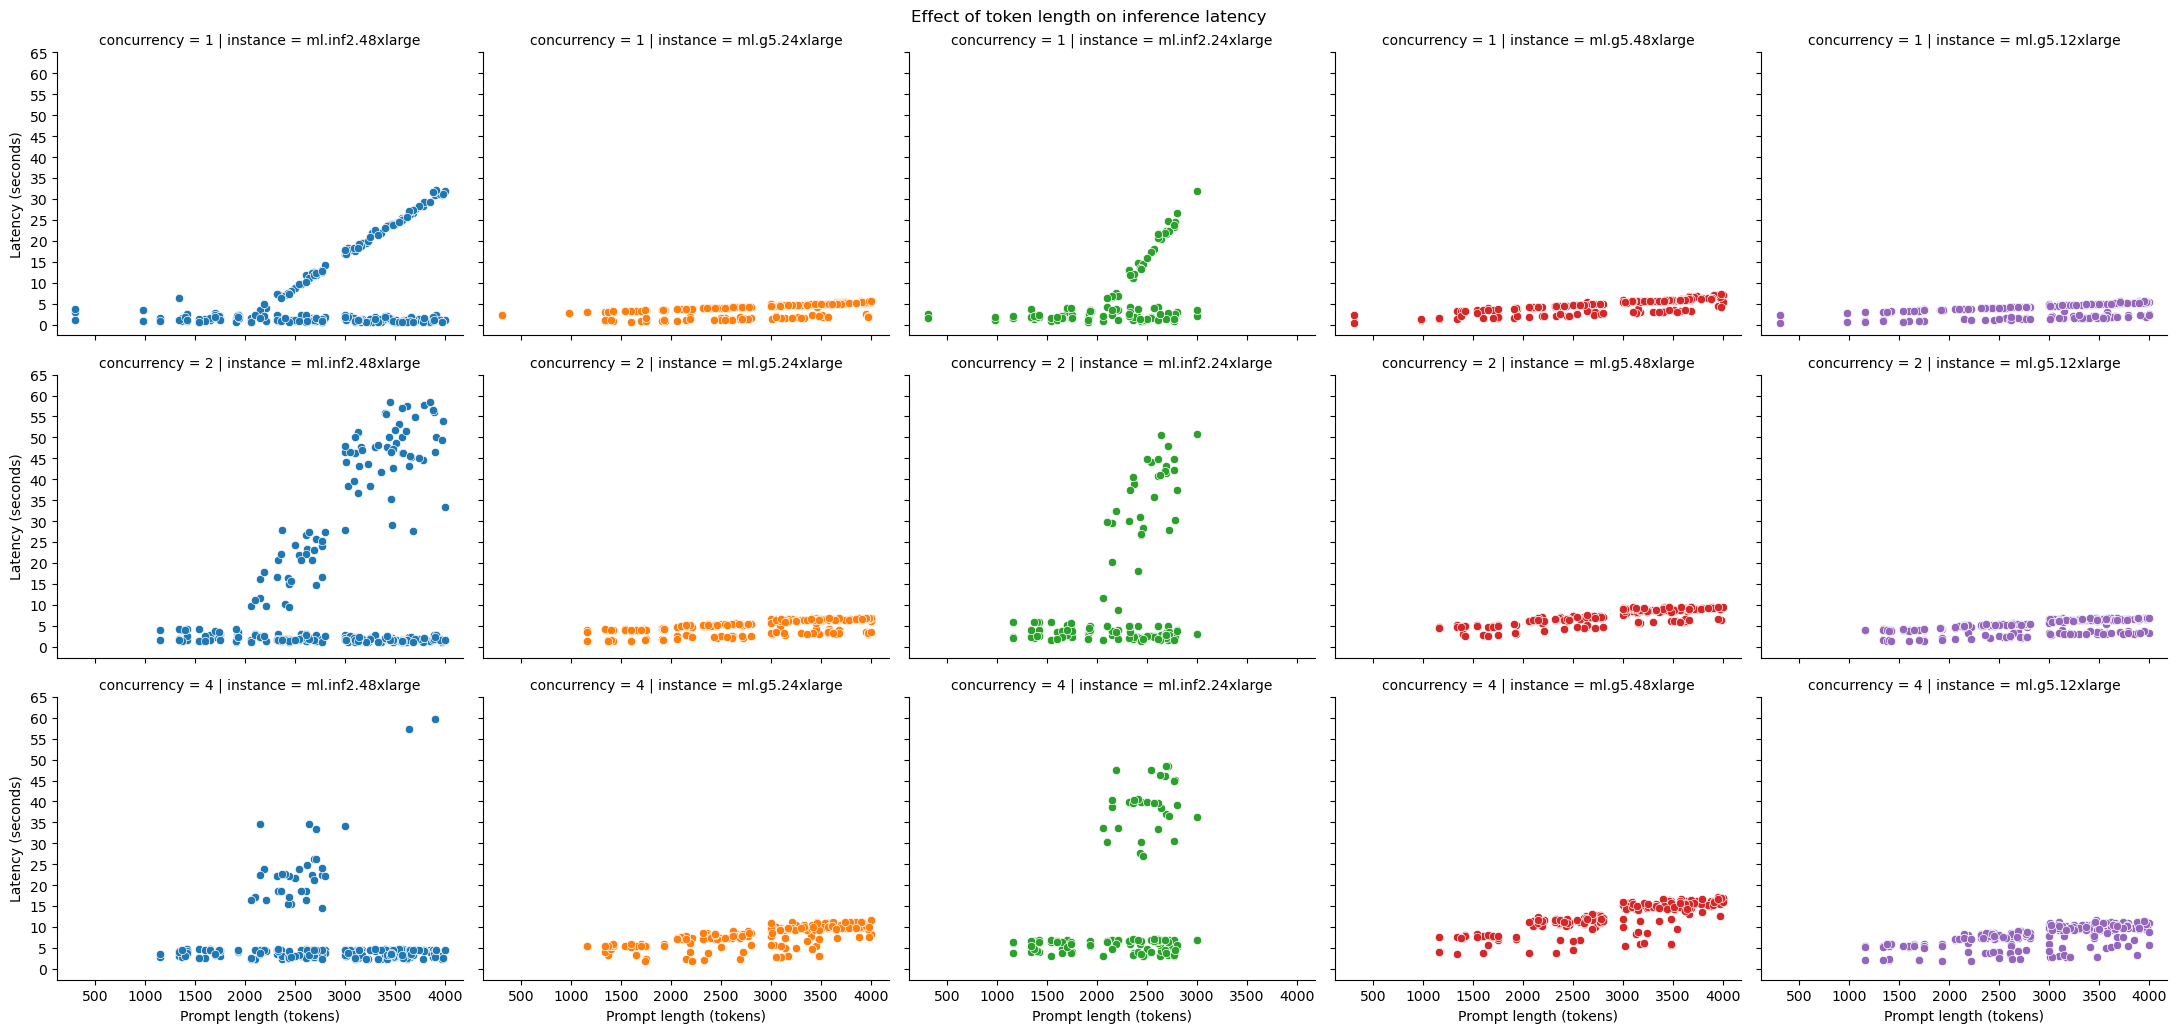

In [8]:
# Rename a column in the dataframe for clarity of the instance parameter of the model used
df_per_inference = df_per_inference.rename(columns={"instance_type": "instance"})


# This created a FacetGrid for plotting multiple scatter plots based on 'instance' and 'concurrency' categories
g = sns.FacetGrid(df_per_inference, col="instance", row="concurrency", hue="instance", height=3.5, aspect=1.25)

## Subtitle of the facetgrid
g.fig.suptitle("Effect of token length on inference latency")

# This will map a scatterplot to the FacetGrid for each subset of the data
sns_plot = g.map(sns.scatterplot, "prompt_tokens", "latency")

# Set the y-axis label for all plots
g = g.set_ylabels("Latency (seconds)")

# Y-axis ticks based on the maximum latency value and setting them in that manner
yticks: List = list(range(0, (int(df_per_inference.latency.max())//10+2)*10, 5))
g = g.set(yticks=yticks)

# Set the x-axis label for all plots as the prompt length or tokens
g = g.set_xlabels("Prompt length (tokens)")

fpath: str = os.path.join(METRICS_DIR, TOKENS_VS_LATENCY_PLOT_FNAME)
sns_plot.savefig(fpath)

## Display the plot for further analysis
sns_plot

#### Define the all metrics file path and read it to generate visualizations

In [9]:
all_metrics_fpath: str = os.path.join(METRICS_DIR, config["results"]["all_metrics_file"])

df_all_metrics = pd.read_csv(all_metrics_fpath)
logger.info(f"{all_metrics_fpath} contains {df_all_metrics.shape[0]} results")
df_all_metrics.head()

[2024-01-19 01:00:20,725] p1570 {793450579.py:4} INFO - data/metrics/llama2-13b-inf2-g5-p4d-v1/all_metrics.csv contains 2399 results


,experiment_name,concurrency,payload_file,errors,successes,error_rate,all_prompts_token_count,prompt_token_count_mean,prompt_token_throughput,all_completions_token_count,...,ModelName,Image,S3Uri,OPTION_DTYPE,OPTION_MAX_ROLLING_BATCH_SIZE,OPTION_NEURON_OPTIMIZE_LEVEL,OPTION_N_POSITIONS,OPTION_ROLLING_BATCH,OPTION_TENSOR_PARALLEL_DEGREE,SAGEMAKER_MODEL_SERVER_WORKERS
0,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,1,payload_en_3000-4000.jsonl,[],1,0.0,3171,3171.0,684.57,102,...,meta-textgeneration-llama-2-13b-2024-01-18-22-...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,s3://jumpstart-private-cache-prod-us-east-1/me...,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,2,payload_en_1000-2000.jsonl,[],2,0.0,3143,1571.5,1749.91,26,...,meta-textgeneration-llama-2-13b-2024-01-18-22-...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,s3://jumpstart-private-cache-prod-us-east-1/me...,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,1,payload_en_3000-4000.jsonl,[],1,0.0,3458,3458.0,1583.48,21,...,meta-textgeneration-llama-2-13b-2024-01-18-22-...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,s3://jumpstart-private-cache-prod-us-east-1/me...,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,llama2-13b-inf2.48xlarge-djl-0.24.0-neuronx-sd...,2,payload_en_3000-4000.jsonl,[],2,0.0,7056,3528.0,5431.72,15,...,meta-textgenerationneuron-llama-2-13b-f-2024-0...,763104351884.dkr.ecr.us-east-1.amazonaws.com/d...,s3://jumpstart-private-cache-prod-us-east-1/me...,fp16,4.0,2.0,4096.0,auto,24.0,1.0
4,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,1,payload_en_3000-4000.jsonl,[],1,0.0,3581,3581.0,720.94,102,...,meta-textgeneration-llama-2-13b-2024-01-18-22-...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,s3://jumpstart-private-cache-prod-us-east-1/me...,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [10]:
## displaying all of the available columns in the all metrics dataframe
df_all_metrics.columns

Index(['experiment_name', 'concurrency', 'payload_file', 'errors', 'successes',
       'error_rate', 'all_prompts_token_count', 'prompt_token_count_mean',
       'prompt_token_throughput', 'all_completions_token_count',
       'completion_token_count_mean', 'completion_token_throughput',
       'transactions', 'transactions_per_second', 'transactions_per_minute',
       'latency_mean', 'instance_type', 'EndpointName', 'ModelName', 'Image',
       'S3Uri', 'OPTION_DTYPE', 'OPTION_MAX_ROLLING_BATCH_SIZE',
       'OPTION_NEURON_OPTIMIZE_LEVEL', 'OPTION_N_POSITIONS',
       'OPTION_ROLLING_BATCH', 'OPTION_TENSOR_PARALLEL_DEGREE',
       'SAGEMAKER_MODEL_SERVER_WORKERS'],
      dtype='object')

#### Display the number of experiment names within the metrics dataframe, instance types and models

In [11]:
experiments = df_all_metrics.experiment_name.unique()
instance_types = df_all_metrics.instance_type.unique()
model_names = df_all_metrics.ModelName.unique()
logger.info(f"contains information about {len(experiments)} experiments, {len(instance_types)} instance types, {len(model_names)} models")

[2024-01-19 01:00:20,899] p1570 {369708136.py:4} INFO - contains information about 6 experiments, 6 instance types, 6 models


In [12]:
## extract some of the columns
relevant_cols = ['experiment_name',
                   'payload_file',
                     'instance_type',
                       'concurrency',
                         'error_rate',
                           'prompt_token_count_mean',
                             'prompt_token_throughput',
                               'completion_token_count_mean',
                                 'completion_token_throughput',
                                   'latency_mean',
                                     'transactions_per_minute']

## initialize a group by columns to use further in generating portions of the dataframe and filtering it
group_by_cols = ['experiment_name',
                   'payload_file',
                     'instance_type',
                      'concurrency']


#### Create an 'experiment_counts.csv' to store metrics on experiment name, the pauloaf file, concurrency and the total counts associated to that given experiment to visualize the distribution

In [13]:
COUNTS_FNAME: str = "experiment_counts.csv"
fpath: str = os.path.join(METRICS_DIR, COUNTS_FNAME)
df_counts = df_all_metrics[group_by_cols].value_counts().reset_index()
df_counts.to_csv(fpath, index=False)
df_counts

,experiment_name,payload_file,instance_type,concurrency,count
0,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.24xlarge,1,171
1,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.12xlarge,1,171
2,llama2-13b-inf2.48xlarge-djl-0.24.0-neuronx-sd...,payload_en_3000-4000.jsonl,ml.inf2.48xlarge,1,171
3,llama2-13b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.48xlarge,1,114
4,llama2-13b-inf2.48xlarge-djl-0.24.0-neuronx-sd...,payload_en_2000-3000.jsonl,ml.inf2.48xlarge,1,96
5,llama2-13b-inf2.24xlarge-djl-0.24.0-neuronx-sd...,payload_en_2000-3000.jsonl,ml.inf2.24xlarge,1,96
6,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.12xlarge,1,96
7,llama2-13b-g5.24xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.24xlarge,1,96
8,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.12xlarge,2,84
9,llama2-13b-inf2.48xlarge-djl-0.24.0-neuronx-sd...,payload_en_3000-4000.jsonl,ml.inf2.48xlarge,2,84


#### Display the mean error rates for each experiment with different congifurations using the same columns of interest used in the cell above

In [14]:
ERROR_RATES_FNAME: str = "error_rates.csv"
fpath: str = os.path.join(METRICS_DIR, ERROR_RATES_FNAME)
df_error_rates = df_all_metrics.groupby(group_by_cols).agg({'error_rate': 'mean'}).reset_index()
df_error_rates = df_error_rates.round(2)
df_error_rates.to_csv(fpath, index=False)
df_error_rates


,experiment_name,payload_file,instance_type,concurrency,error_rate
0,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.12xlarge,1,0.00
1,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1000-2000.jsonl,ml.g5.12xlarge,1,0.00
2,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1000-2000.jsonl,ml.g5.12xlarge,2,0.00
3,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1000-2000.jsonl,ml.g5.12xlarge,4,0.00
4,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.12xlarge,1,0.00
5,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.12xlarge,2,0.00
6,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.12xlarge,4,0.00
7,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.12xlarge,1,0.00
8,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.12xlarge,2,0.00
9,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.12xlarge,4,0.00


### Visualize Inference error rates across different concurrency levels and instance types

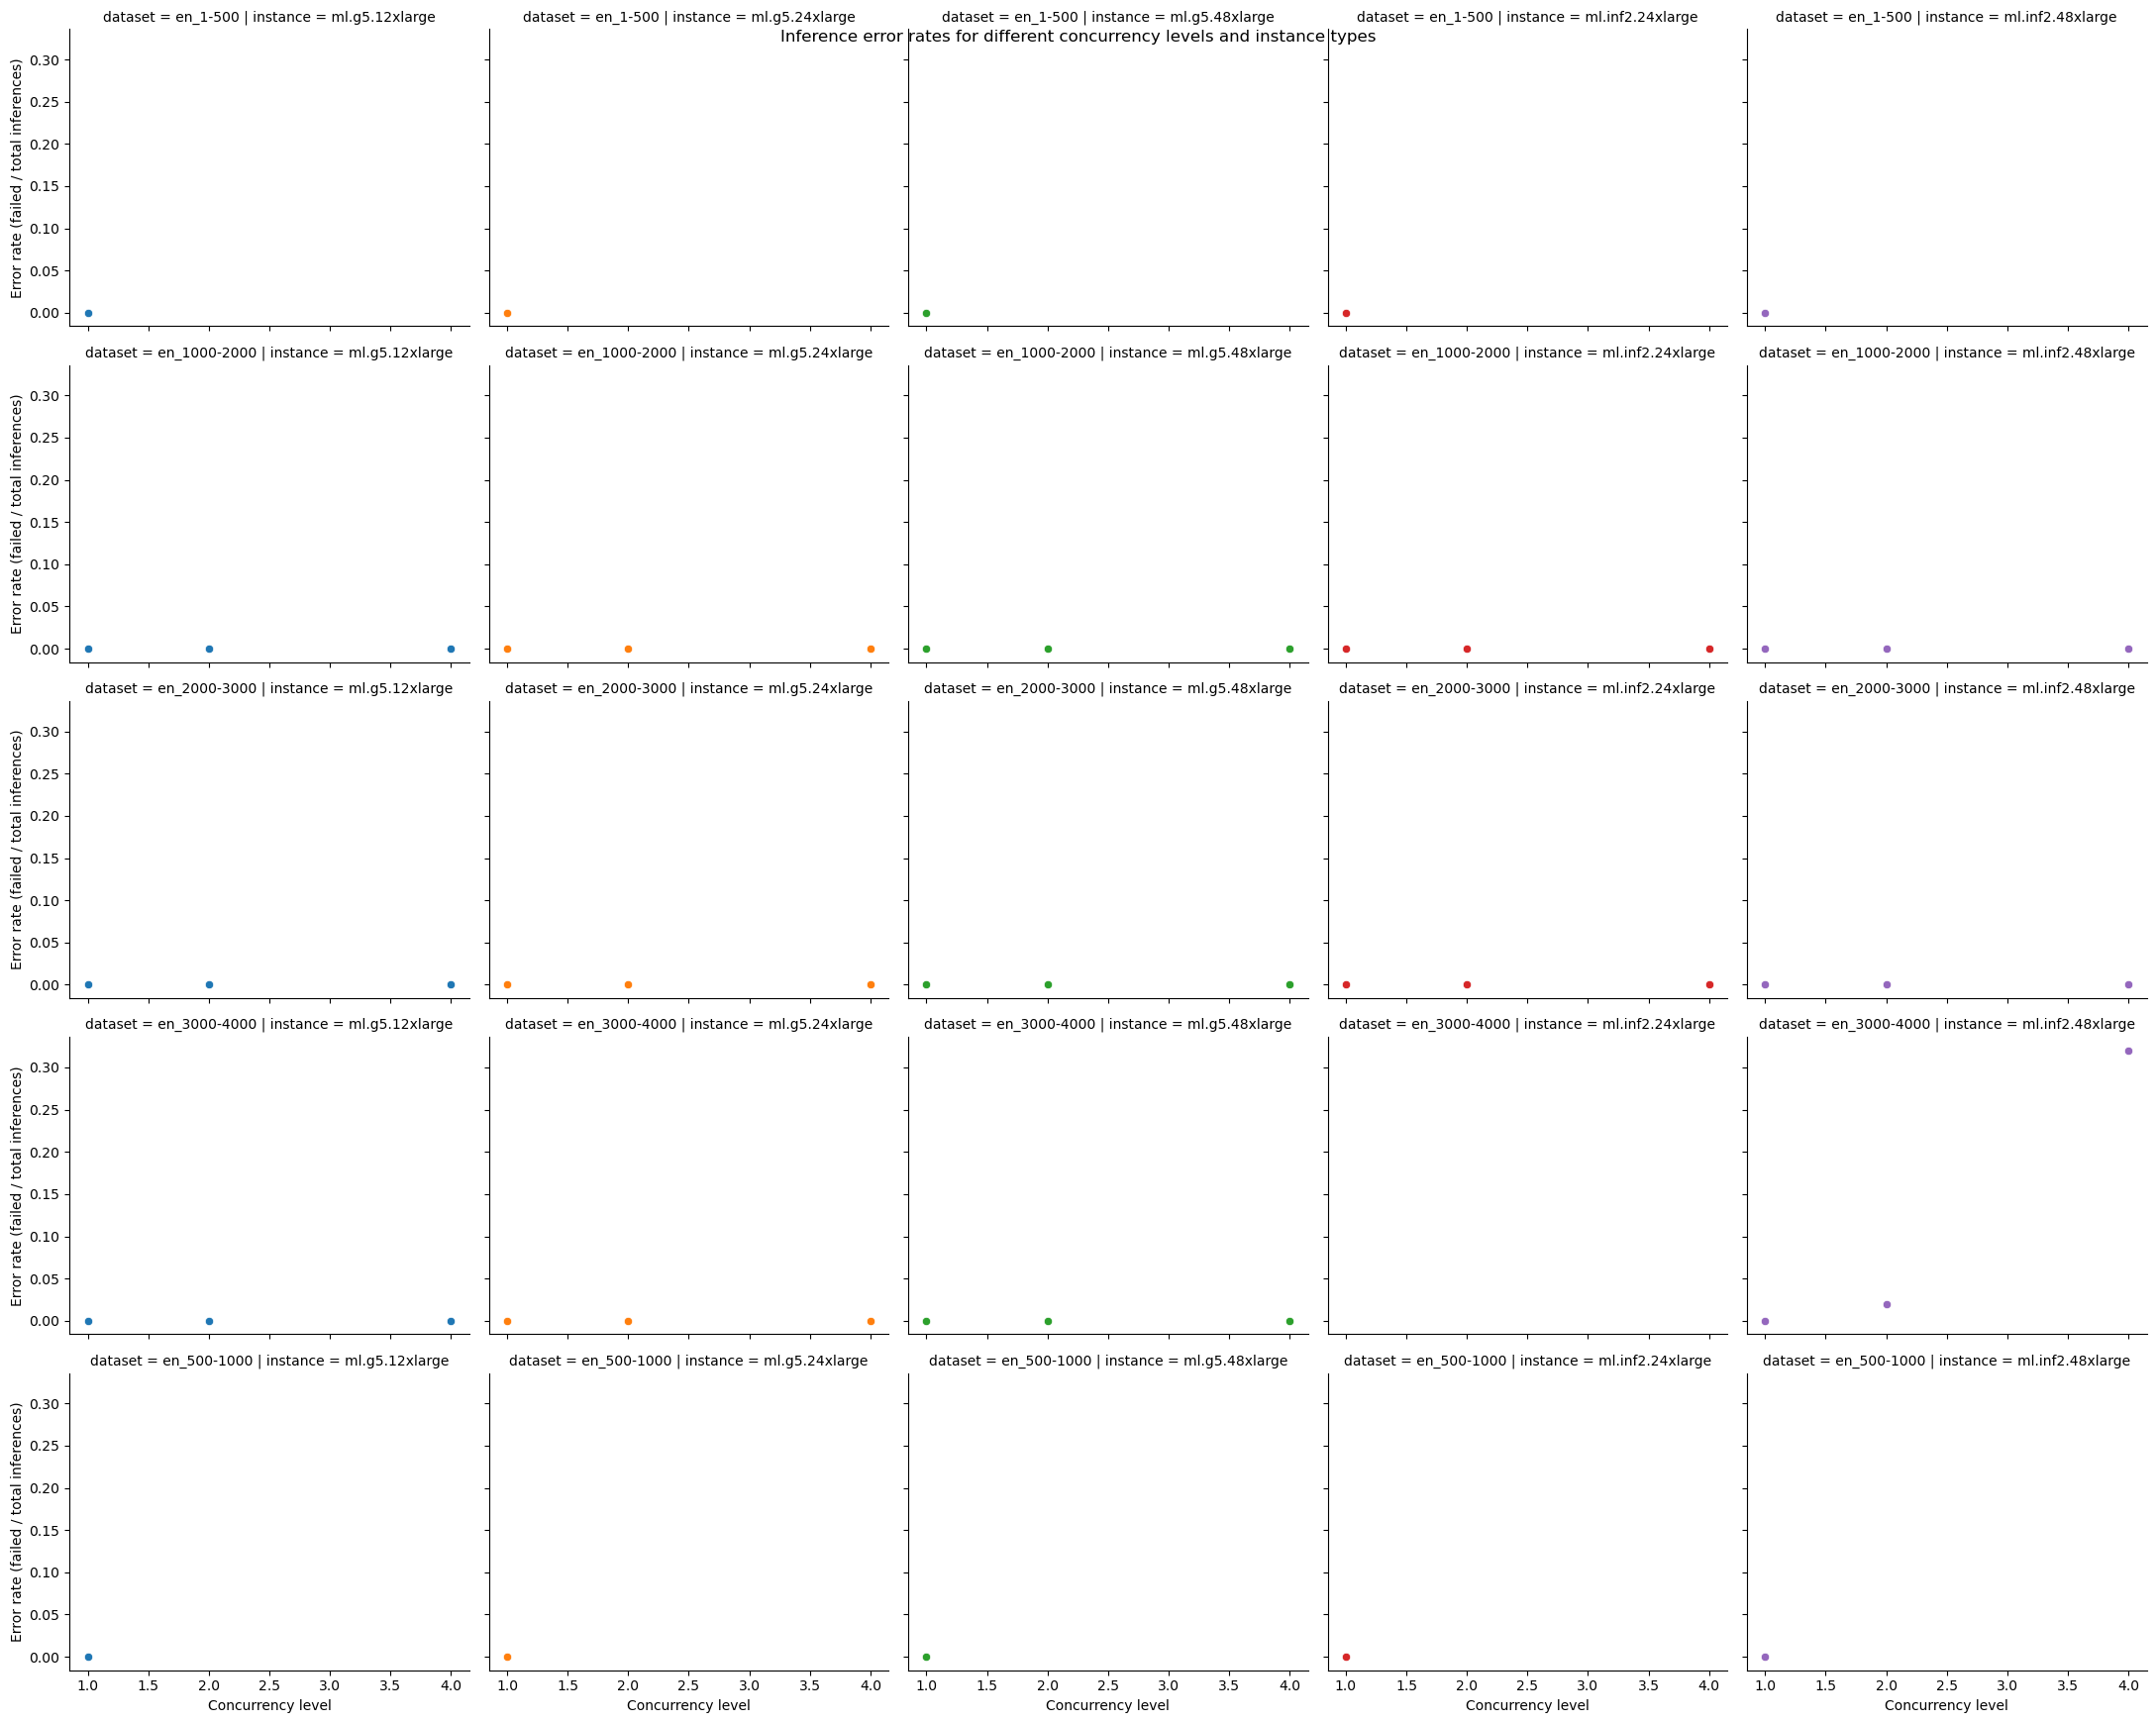

In [15]:
df_error_rates = df_error_rates.rename(columns={"instance_type": "instance", "payload_file": "dataset"})

# Clean up the dataset names by removing json file extensions and prefixes
df_error_rates.dataset = df_error_rates.dataset.map(lambda x: x.replace(".jsonl", "").replace("payload_", ""))

# this creates a facetGrid for plotting scatter plots based on 'instance' and 'dataset'
g = sns.FacetGrid(df_error_rates, col="instance", row="dataset", hue="instance", height=3.5, aspect=1.25)

# Maps a scatterplot to the FacetGrid for each subset of the data
sns_plot = g.map(sns.scatterplot, "concurrency", "error_rate")

# Create a subtitle
g.fig.suptitle("Inference error rates for different concurrency levels and instance types")

## Set x and y labels for this chart
g = g.set_ylabels("Error rate (failed / total inferences)")
g = g.set_xlabels("Concurrency level")


fpath: str = os.path.join(METRICS_DIR, ERROR_RATES_PLOT_FNAME)
sns_plot.savefig(fpath)

## Display the plot 
sns_plot

#### Check for the df elements that have error rates above 0

In [16]:
df_error_rates_nz = df_error_rates[df_error_rates.error_rate > 0]
df_error_rates_nz

,experiment_name,dataset,instance,concurrency,error_rate
49,llama2-13b-inf2.48xlarge-djl-0.24.0-neuronx-sd...,en_3000-4000,ml.inf2.48xlarge,2,0.02
50,llama2-13b-inf2.48xlarge-djl-0.24.0-neuronx-sd...,en_3000-4000,ml.inf2.48xlarge,4,0.32


In [17]:
## initialize a dataframe to get the mean of the columns in consideration
df_summary_metrics = df_all_metrics[relevant_cols].groupby(group_by_cols).mean().reset_index()

# ugly way of doing this, will refactor this later (maybe)
df_summary_metrics.fillna(PLACE_HOLDER, inplace=True)
int_cols = ['prompt_token_count_mean', 'prompt_token_throughput', 'completion_token_count_mean', 'completion_token_throughput', 'transactions_per_minute']
for ic in int_cols:
    df_summary_metrics[ic] = df_summary_metrics[ic].astype(int)

df_summary_metrics.replace(PLACE_HOLDER, np.nan, inplace=True)
df_summary_metrics.latency_mean	= df_summary_metrics.latency_mean.round(2)
df_summary_metrics.error_rate	= df_summary_metrics.error_rate.round(2)

fpath: str = all_metrics_fpath.replace("all_metrics", "all_metrics_summary")
df_summary_metrics.to_csv(fpath, index=False)
df_summary_metrics

,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,transactions_per_minute
0,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.12xlarge,1,0.00,304,349,71,36,1.64,68
1,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1000-2000.jsonl,ml.g5.12xlarge,1,0.00,1623,812,79,25,2.73,30
2,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1000-2000.jsonl,ml.g5.12xlarge,2,0.00,1600,878,78,38,3.43,32
3,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_1000-2000.jsonl,ml.g5.12xlarge,4,0.00,1548,1039,80,54,4.82,39
4,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.12xlarge,1,0.00,2503,817,87,22,3.62,19
5,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.12xlarge,2,0.00,2503,1038,83,31,4.63,24
6,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.12xlarge,4,0.00,2503,1187,85,40,7.10,28
7,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.12xlarge,1,0.00,3478,1009,78,16,4.12,17
8,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.12xlarge,2,0.00,3482,1119,81,24,5.79,18
9,llama2-13b-g5.12xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.12xlarge,4,0.00,3482,1296,88,32,9.34,21


In [18]:
df_summary_metrics_nz = df_summary_metrics[df_summary_metrics.error_rate == 0]
logger.info(f"there are {len(df_summary_metrics_nz)} entries out of {len(df_summary_metrics)} in the summary data for which error rate is 0")

[2024-01-19 01:00:29,000] p1570 {3483828648.py:2} INFO - there are 50 entries out of 52 in the summary data for which error rate is 0


In [19]:

from typing import Optional
dttm = str(datetime.utcnow())
#RESULT_ROW: str = "|`{dataset}`|`{instance_type}`|{desc}|"
#RESULT_DESC: str = """The best option for staying within a latency budget of `{latency_budget} seconds` on a `{instance_type}` for the `{dataset}` dataset is a `concurrency level of {concurrency}`. A concurrency level of {concurrency} achieves an `average latency of {latency_mean} seconds`, for an `average prompt size of {prompt_size} tokens` and `completion size of {completion_size} tokens` with `{tpm} transactions/minute`."""

overall_results_md = OVERALL_RESULTS_MD.format(dttm=dttm)
results_group_cols: List[str] = ['instance_type', 'payload_file']
result_rows: List[str] = []
for row in df_summary_metrics[results_group_cols].drop_duplicates().iterrows():
    instance_type = row[1]['instance_type']
    dataset = row[1]['payload_file']
    df_summary_metrics_nz_subset = df_summary_metrics_nz[(df_summary_metrics_nz.instance_type == instance_type) &
                                                          (df_summary_metrics_nz.payload_file == dataset) &
                                                           (df_summary_metrics_nz.latency_mean <= LATENCY_BUDGET)]
    num_results = df_summary_metrics_nz_subset.shape[0]
    result_row: Optional[str] = None
    if num_results > 0:
        logger.info(f"there are {num_results} options to choose the best option from for instance_type={instance_type}, dataset={dataset}")
        df_summary_metrics_nz_subset_selected = df_summary_metrics_nz_subset[df_summary_metrics_nz_subset.concurrency == df_summary_metrics_nz_subset.concurrency.max()]
        best = df_summary_metrics_nz_subset_selected.to_dict(orient='records')[0]
        # logger.info(best)
        result_desc = RESULT_DESC.format(latency_budget=LATENCY_BUDGET,
                           instance_type=best['instance_type'],
                           dataset=dataset,
                           concurrency=best['concurrency'],
                           latency_mean=best['latency_mean'],
                           prompt_size=int(best['prompt_token_count_mean']),
                           completion_size=int(best['completion_token_count_mean']),
                           tpm=int(best['transactions_per_minute']))     
        
        # logger.info(result_desc)
    else:
        logger.info(f"there are NO options to choose from for instance_type={instance_type}, dataset={dataset}")
        result_desc = RESULT_FAILURE_DESC.format(latency_budget=LATENCY_BUDGET,
                           instance_type=best['instance_type'],
                           dataset=dataset)
    result_row: str = RESULT_ROW.format(instance_type=best['instance_type'],
                                        dataset=dataset,
                                        desc=result_desc)
    result_rows.append(result_row)
        
    
    #logger.info(f"instance_type={row[0]}, payload_file={row[1]}")
overall_results_md += "\n".join(result_rows)
logger.info(overall_results_md)



[2024-01-19 01:00:29,109] p1570 {3483931720.py:18} INFO - there are 1 options to choose the best option from for instance_type=ml.g5.12xlarge, dataset=payload_en_1-500.jsonl
[2024-01-19 01:00:29,119] p1570 {3483931720.py:18} INFO - there are 3 options to choose the best option from for instance_type=ml.g5.12xlarge, dataset=payload_en_1000-2000.jsonl
[2024-01-19 01:00:29,126] p1570 {3483931720.py:18} INFO - there are 3 options to choose the best option from for instance_type=ml.g5.12xlarge, dataset=payload_en_2000-3000.jsonl
[2024-01-19 01:00:29,133] p1570 {3483931720.py:18} INFO - there are 3 options to choose the best option from for instance_type=ml.g5.12xlarge, dataset=payload_en_3000-4000.jsonl
[2024-01-19 01:00:29,138] p1570 {3483931720.py:18} INFO - there are 1 options to choose the best option from for instance_type=ml.g5.12xlarge, dataset=payload_en_500-1000.jsonl
[2024-01-19 01:00:29,145] p1570 {3483931720.py:18} INFO - there are 1 options to choose the best option from for in

In [20]:
OVERALL_RESULTS_PLOTS_MD: str = """

## Plots

The following plots provide insights into the results from the different experiments run.

![{plot1_text}]({plot1_fname})

![{plot2_text}]({plot2_fname})
"""

overall_results_plots_md: str = OVERALL_RESULTS_PLOTS_MD.format(plot1_text=ERROR_RATES_PLOT_TEXT, 
                                                                plot1_fname=ERROR_RATES_PLOT_FNAME,
                                                                plot2_text=TOKENS_VS_LATENCY_PLOT_TEXT, 
                                                                plot2_fname=TOKENS_VS_LATENCY_PLOT_FNAME)

overall_results_md += overall_results_plots_md

In [21]:
fpath: str = os.path.join(METRICS_DIR, RESULTS_DESC_MD_FNAME)
logger.info(f"going to write overall results description to {fpath}")
Path(fpath).write_text(overall_results_md)

[2024-01-19 01:00:29,405] p1570 {3574979679.py:2} INFO - going to write overall results description to data/metrics/llama2-13b-inf2-g5-p4d-v1/results.md


10065